# Step 1: Import required libraries

In [1]:
import tweepy #---to get tweets from twitter
import pandas as pd #---pandas for data processing

import numpy as np #--- to help set tick values in matplotlib
import re #---for data manipulations using regulaar expressions
from collections import Counter as cnt #---to compute word frequencies in a dictionary

import matplotlib.pyplot as plt #---for plotting
import seaborn as sns #---for plotting

from gensim.parsing.preprocessing import remove_stopwords #---for NLP; removing stopwords from tweets
from textblob import TextBlob #---for NLP
from wordcloud import WordCloud #---for visualization of word clouds

# Step 2: Extract tweets from twitter and save in a dataframe

## 2.1 Initialize twitter API authorization components

In [2]:
consumer_key = 'cbhTByvk34jPgDACTQDRdJmJl'
consumer_secret = 'OHbPmt9VgjL5vnUpobrDT4ymFiqbRQ22l53d3HI9e1dkGOqyEI'

access_token = '1323666130897088520-dMDHAYfTacMf5eBEpLSCcVKX91DoUH'
access_token_secret = 'MvSZ7DGGTCZaPJHso7vTUVjM0gsIdsnAytEfNba41IvUy'

## 2.2 Authorize twitter API

In [3]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

## 2.3 Initialize query components/ parameters

Initial trial was to get tweets from United Kingdom since it would give a better interpretation.   
But unfortunately the number of tweets for #CovidVaccination when restricted to United Kingdom was around 50. Since we needed 500 tweets, the place filter was removed.

The search term has -#DrongoVaccineAlert because of a lot of tweets from an automated bot regarding vaccine availability (https://twitter.com/hashtag/DrongoVaccineAlert?src=hashtag_click)  
Since we want to perform sentiment analysis on tweets from people, this term is ignored in our search

In [4]:
#-----Initialize required variables/ parameters
#search_term = "#CovidVaccination OR #CovidVaccination OR #CovidVaccine OR #CovidVaccine OR #CovidJab OR #covidjab OR #Vaccinated OR #Vaccinated"
search_term = "#CovidVaccination -#DrongoVaccineAlert"

#-----number of tweets to retreive
tweet_count=500

#-----get the place_id for United Kingdom since we are going to analyze tweets only from the UK
# places = api.geo_search(query="United Kingdom", granularity="country")

# place_id = ''
# for pl in places:
#     if pl.country_code=='GB':
#         place_id = pl.id
#     else:
#         continue

#### Retreive tweets and save in a dataframe

In [5]:
#public_tweets = tweepy.Cursor(api.search , q='{} -filter:retweets place:{}'.format(search_term, place_id), lang="en", since='2021-01-01').items(tweet_count)
public_tweets = tweepy.Cursor(api.search , q='{} -filter:retweets'.format(search_term), lang="en", since='2021-03-01').items(tweet_count)
json_data = [r._json for r in public_tweets]
public_tweets_df = pd.json_normalize(json_data)
public_tweets_df

,created_at,id,id_str,text,truncated,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,quoted_status.place.full_name,quoted_status.place.country_code,quoted_status.place.country,quoted_status.place.contained_within,quoted_status.place.bounding_box.type,quoted_status.place.bounding_box.coordinates,geo.type,geo.coordinates,coordinates.type,coordinates.coordinates
0,Mon May 31 17:42:23 +0000 2021,1399421011720769546,1399421011720769546,First in India 🙏\n\n#COVIDVaccination https://...,False,"<a href=""http://twitter.com/download/android"" ...",NaN,None,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Mon May 31 17:39:18 +0000 2021,1399420235715792898,1399420235715792898,"Today India is a polio free country, because o...",True,"<a href=""http://twitter.com/download/android"" ...",NaN,None,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Mon May 31 17:39:18 +0000 2021,1399420234377818118,1399420234377818118,Just now tried to book a slot for vaccination ...,True,"<a href=""http://twitter.com/download/android"" ...",NaN,None,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Mon May 31 17:36:43 +0000 2021,1399419582960472064,1399419582960472064,At what period of time that every Indian citiz...,True,"<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,None,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Mon May 31 17:35:43 +0000 2021,1399419333856530441,1399419333856530441,If people start conducting tests for antibodie...,True,"<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,None,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,Sun May 30 04:30:11 +0000 2021,1398859260642172928,1398859260642172928,Now you know the importance of vaccination and...,True,"<a href=""https://buffer.com"" rel=""nofollow"">Bu...",NaN,None,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
496,Sun May 30 04:28:19 +0000 2021,1398858790821191681,1398858790821191681,#Pune: Special #VaccinationDrive for #students...,True,"<a href=""http://twitter.com/download/android"" ...",NaN,None,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
497,Sun May 30 04:13:23 +0000 2021,1398855031131017216,1398855031131017216,"If election campaign can happen door to door, ...",True,"<a href=""http://twitter.com/download/android"" ...",NaN,None,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
498,Sun May 30 03:50:04 +0000 2021,1398849164985868293,1398849164985868293,21.21 crore shots given in India till date #Co...,False,"<a href=""http://twitter.com/download/iphone"" r...",NaN,None,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Step 3: Data Cleansing

## 3.1 Extract the tweet text in a new dataframe
The original dataframe is untouched to have a backup copy of original data

In [6]:
pd.set_option('display.max_colwidth', None)
pd.options.mode.chained_assignment = None

tweets_df = public_tweets_df[['text']]
tweets_df

,text
0,First in India 🙏\n\n#COVIDVaccination https://t.co/aH7LwePX1Y
1,"Today India is a polio free country, because of the initiative of vaccinating every child goin door to door. This m… https://t.co/mNtsMze5iF"
2,"Just now tried to book a slot for vaccination and it got booked for today 31st May, 9am to 6pm. Can I get some time… https://t.co/cAa3e2hich"
3,At what period of time that every Indian citizens can say we are vaccinated..? \n\n#CovidVaccineIndia… https://t.co/BI5HUez6Rb
4,"If people start conducting tests for antibodies before &amp; after 30 days of #COVIDVaccination, I think, all #VAX cos… https://t.co/Mpjt2ZXRMH"
...,...
495,Now you know the importance of vaccination and it's purpose.\nBe responsible for your own and your family's safety.… https://t.co/PIEVosKDis
496,#Pune: Special #VaccinationDrive for #students going abroad for #studies @PMCPune #COVIDVaccination… https://t.co/15V3SZLjUN
497,"If election campaign can happen door to door, then why can't testing/vaccination ?\n\n@PMOIndia\n@CMO_Odisha… https://t.co/RLkubG2bUI"
498,21.21 crore shots given in India till date #CovidVaccination https://t.co/wW4ylTphJD


## 3.2 Clean the tweets
#### Remove the following,
##### - _twitter handles (@yyyyy)_
##### - _numbers_
##### - _URLs_
##### - _alphanumeric words_
##### - _punctuations_
##### - _special characters except # (we will use hashtags for further analysis)_

In [7]:
#---remove twitter handles
tweets_df['cleaned_tweet'] = tweets_df['text'].apply(lambda x: re.sub(r"@[\w]*", "", x)) 

#---remove URLs
tweets_df['cleaned_tweet'] = tweets_df['cleaned_tweet'].apply(lambda x: re.sub(r"http\S+", "", x))

#---remove numeric and alphanumeric words
tweets_df['cleaned_tweet'] = tweets_df['cleaned_tweet'].apply(lambda x: re.sub('\w*\d\w*', "", x))

#---remove components other than alphabets, # and 19. This will remove punctuations, alphanumeric words except ones with 19 like covid19.
tweets_df['cleaned_tweet'] = tweets_df['cleaned_tweet'].apply(lambda x: re.sub('[^A-Za-z#.19]', ' ', x)) 

#---save hashstags in tweets to a different column. Filter empty hashtags. 
tweets_df['complimentary_hashtags'] = tweets_df.cleaned_tweet.apply(lambda x: [i for i in str(x).split() if (i.startswith('#') and i!='#')]) 

#---remove hashtags in cleaned tweets. We do not need hastags for calculating polarity & subjectivity.
tweets_df['cleaned_tweet'] = tweets_df['cleaned_tweet'].apply(lambda x: re.sub('\#\w*', '', x)) 

tweets_df

,text,cleaned_tweet,complimentary_hashtags
0,First in India 🙏\n\n#COVIDVaccination https://t.co/aH7LwePX1Y,First in India,[#COVIDVaccination]
1,"Today India is a polio free country, because of the initiative of vaccinating every child goin door to door. This m… https://t.co/mNtsMze5iF",Today India is a polio free country because of the initiative of vaccinating every child goin door to door. This m,[]
2,"Just now tried to book a slot for vaccination and it got booked for today 31st May, 9am to 6pm. Can I get some time… https://t.co/cAa3e2hich",Just now tried to book a slot for vaccination and it got booked for today May to . Can I get some time,[]
3,At what period of time that every Indian citizens can say we are vaccinated..? \n\n#CovidVaccineIndia… https://t.co/BI5HUez6Rb,At what period of time that every Indian citizens can say we are vaccinated..,[#CovidVaccineIndia]
4,"If people start conducting tests for antibodies before &amp; after 30 days of #COVIDVaccination, I think, all #VAX cos… https://t.co/Mpjt2ZXRMH",If people start conducting tests for antibodies before amp after days of I think all cos,"[#COVIDVaccination, #VAX]"
...,...,...,...
495,Now you know the importance of vaccination and it's purpose.\nBe responsible for your own and your family's safety.… https://t.co/PIEVosKDis,Now you know the importance of vaccination and it s purpose. Be responsible for your own and your family s safety.,[]
496,#Pune: Special #VaccinationDrive for #students going abroad for #studies @PMCPune #COVIDVaccination… https://t.co/15V3SZLjUN,Special for going abroad for,"[#Pune, #VaccinationDrive, #students, #studies, #COVIDVaccination]"
497,"If election campaign can happen door to door, then why can't testing/vaccination ?\n\n@PMOIndia\n@CMO_Odisha… https://t.co/RLkubG2bUI",If election campaign can happen door to door then why can t testing vaccination,[]
498,21.21 crore shots given in India till date #CovidVaccination https://t.co/wW4ylTphJD,. crore shots given in India till date,[#CovidVaccination]


## 3.3 Compute polarity and subjectivity

In [8]:
tweets_df['polarity'] = tweets_df.cleaned_tweet.apply(lambda x: TextBlob(x).polarity)
tweets_df['subjectivity'] = tweets_df.cleaned_tweet.apply(lambda x: TextBlob(x).subjectivity)
tweets_df

,text,cleaned_tweet,complimentary_hashtags,polarity,subjectivity
0,First in India 🙏\n\n#COVIDVaccination https://t.co/aH7LwePX1Y,First in India,[#COVIDVaccination],0.250000,0.333333
1,"Today India is a polio free country, because of the initiative of vaccinating every child goin door to door. This m… https://t.co/mNtsMze5iF",Today India is a polio free country because of the initiative of vaccinating every child goin door to door. This m,[],0.400000,0.800000
2,"Just now tried to book a slot for vaccination and it got booked for today 31st May, 9am to 6pm. Can I get some time… https://t.co/cAa3e2hich",Just now tried to book a slot for vaccination and it got booked for today May to . Can I get some time,[],0.000000,0.000000
3,At what period of time that every Indian citizens can say we are vaccinated..? \n\n#CovidVaccineIndia… https://t.co/BI5HUez6Rb,At what period of time that every Indian citizens can say we are vaccinated..,[#CovidVaccineIndia],0.000000,0.000000
4,"If people start conducting tests for antibodies before &amp; after 30 days of #COVIDVaccination, I think, all #VAX cos… https://t.co/Mpjt2ZXRMH",If people start conducting tests for antibodies before amp after days of I think all cos,"[#COVIDVaccination, #VAX]",0.000000,0.000000
...,...,...,...,...,...
495,Now you know the importance of vaccination and it's purpose.\nBe responsible for your own and your family's safety.… https://t.co/PIEVosKDis,Now you know the importance of vaccination and it s purpose. Be responsible for your own and your family s safety.,[],0.400000,0.775000
496,#Pune: Special #VaccinationDrive for #students going abroad for #studies @PMCPune #COVIDVaccination… https://t.co/15V3SZLjUN,Special for going abroad for,"[#Pune, #VaccinationDrive, #students, #studies, #COVIDVaccination]",0.357143,0.571429
497,"If election campaign can happen door to door, then why can't testing/vaccination ?\n\n@PMOIndia\n@CMO_Odisha… https://t.co/RLkubG2bUI",If election campaign can happen door to door then why can t testing vaccination,[],0.000000,0.000000
498,21.21 crore shots given in India till date #CovidVaccination https://t.co/wW4ylTphJD,. crore shots given in India till date,[#CovidVaccination],0.000000,0.000000


# _The output of step 3 is tweets_df which contains complementary hashtags, polarity and subjectivity values for cleaned tweets_

# Step 4: Additional text processing

## 4.1 Tokenize cleaned tweets into separate sentences

In [9]:
tweets_df['tokenized_sentences'] = tweets_df.cleaned_tweet.apply(lambda x: [str(y) for y in TextBlob(x).sentences])
tweets_df

,text,cleaned_tweet,complimentary_hashtags,polarity,subjectivity,tokenized_sentences
0,First in India 🙏\n\n#COVIDVaccination https://t.co/aH7LwePX1Y,First in India,[#COVIDVaccination],0.250000,0.333333,[First in India]
1,"Today India is a polio free country, because of the initiative of vaccinating every child goin door to door. This m… https://t.co/mNtsMze5iF",Today India is a polio free country because of the initiative of vaccinating every child goin door to door. This m,[],0.400000,0.800000,"[Today India is a polio free country because of the initiative of vaccinating every child goin door to door., This m]"
2,"Just now tried to book a slot for vaccination and it got booked for today 31st May, 9am to 6pm. Can I get some time… https://t.co/cAa3e2hich",Just now tried to book a slot for vaccination and it got booked for today May to . Can I get some time,[],0.000000,0.000000,"[Just now tried to book a slot for vaccination and it got booked for today May to ., Can I get some time]"
3,At what period of time that every Indian citizens can say we are vaccinated..? \n\n#CovidVaccineIndia… https://t.co/BI5HUez6Rb,At what period of time that every Indian citizens can say we are vaccinated..,[#CovidVaccineIndia],0.000000,0.000000,[At what period of time that every Indian citizens can say we are vaccinated..]
4,"If people start conducting tests for antibodies before &amp; after 30 days of #COVIDVaccination, I think, all #VAX cos… https://t.co/Mpjt2ZXRMH",If people start conducting tests for antibodies before amp after days of I think all cos,"[#COVIDVaccination, #VAX]",0.000000,0.000000,[If people start conducting tests for antibodies before amp after days of I think all cos]
...,...,...,...,...,...,...
495,Now you know the importance of vaccination and it's purpose.\nBe responsible for your own and your family's safety.… https://t.co/PIEVosKDis,Now you know the importance of vaccination and it s purpose. Be responsible for your own and your family s safety.,[],0.400000,0.775000,"[Now you know the importance of vaccination and it s purpose., Be responsible for your own and your family s safety.]"
496,#Pune: Special #VaccinationDrive for #students going abroad for #studies @PMCPune #COVIDVaccination… https://t.co/15V3SZLjUN,Special for going abroad for,"[#Pune, #VaccinationDrive, #students, #studies, #COVIDVaccination]",0.357143,0.571429,[ Special for going abroad for]
497,"If election campaign can happen door to door, then why can't testing/vaccination ?\n\n@PMOIndia\n@CMO_Odisha… https://t.co/RLkubG2bUI",If election campaign can happen door to door then why can t testing vaccination,[],0.000000,0.000000,[If election campaign can happen door to door then why can t testing vaccination]
498,21.21 crore shots given in India till date #CovidVaccination https://t.co/wW4ylTphJD,. crore shots given in India till date,[#CovidVaccination],0.000000,0.000000,"[., crore shots given in India till date]"


## 4.2 Move individual sentences into a new dataframe while retaining polarity and subjectivity values of entire tweet

We prepare this data to get an idea of the words used in tweets according to polarity and subjectivity.

We have to calculate the lemmatized words for which POS tags are necessary.

POS_TAGS have better accuracy when placed on individual statements rather than two or three sentences clubbed together as a paragrah. 

In [10]:
temp_list = []

for i in range(0, len(tweets_df)):
    for j in tweets_df['tokenized_sentences'].iloc[i]:
            temp_list.append([j, tweets_df.polarity.iloc[i], tweets_df.subjectivity.iloc[i]])
        
sentences_df =  pd.DataFrame(temp_list, columns=['tweet_sentence', 'polarity', 'subjectivity'])
sentences_df

,tweet_sentence,polarity,subjectivity
0,First in India,0.250000,0.333333
1,Today India is a polio free country because of the initiative of vaccinating every child goin door to door.,0.400000,0.800000
2,This m,0.400000,0.800000
3,Just now tried to book a slot for vaccination and it got booked for today May to .,0.000000,0.000000
4,Can I get some time,0.000000,0.000000
...,...,...,...
636,Special for going abroad for,0.357143,0.571429
637,If election campaign can happen door to door then why can t testing vaccination,0.000000,0.000000
638,.,0.000000,0.000000
639,crore shots given in India till date,0.000000,0.000000


## 4.3 Lemmatize the individual sentences to get root words and reform sentence

In [11]:
#--https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
def lemmatize_with_postag(sentence):
    sent = TextBlob(sentence)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return " ".join(lemmatized_list)

sentences_df['lemmatized'] = sentences_df['tweet_sentence'].apply(lambda x: lemmatize_with_postag(x))
sentences_df

,tweet_sentence,polarity,subjectivity,lemmatized
0,First in India,0.250000,0.333333,First in India
1,Today India is a polio free country because of the initiative of vaccinating every child goin door to door.,0.400000,0.800000,Today India be a polio free country because of the initiative of vaccinate every child goin door to door
2,This m,0.400000,0.800000,This m
3,Just now tried to book a slot for vaccination and it got booked for today May to .,0.000000,0.000000,Just now try to book a slot for vaccination and it get book for today May to
4,Can I get some time,0.000000,0.000000,Can I get some time
...,...,...,...,...
636,Special for going abroad for,0.357143,0.571429,Special for go abroad for
637,If election campaign can happen door to door then why can t testing vaccination,0.000000,0.000000,If election campaign can happen door to door then why can t test vaccination
638,.,0.000000,0.000000,
639,crore shots given in India till date,0.000000,0.000000,crore shot give in India till date


# _The output of step 4 is sentences_df which contains lemmatized individual statements from tweets with the polarity and subjectivity values of the entire tweets_

# Step 5: Visualizations and Analysis

## 5.1 Plotting polarity of tweets

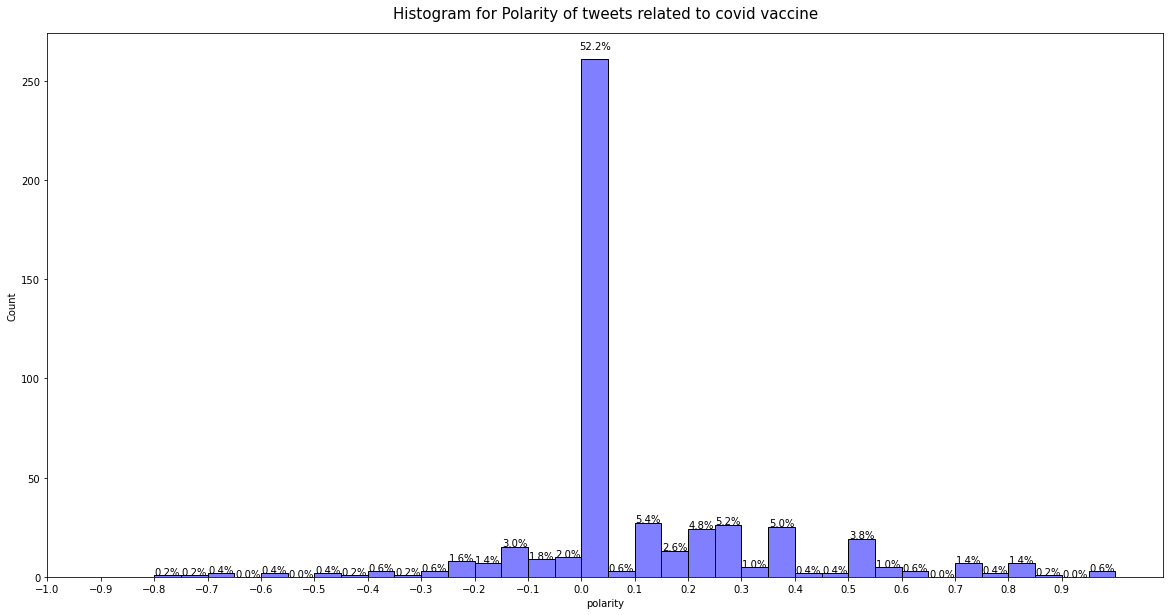

In [12]:
f, ax = plt.subplots(figsize=(20,10))

sns.histplot(tweets_df['polarity'],color='blue', ax=ax, alpha=0.5)
ax.set_xticks(np.arange(-1, 1, .1))

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    pct_val = round(height/len(tweets_df)*100,2)
    x, y = p.get_xy() 
    ax.annotate(f'{pct_val}%', (x + width/2, y + height*1.02), ha='center')
    ax.set_title("Histogram for Polarity of tweets related to covid vaccine", fontsize = 15, pad = 15)

plt.show()

<div class="alert alert-block alert-info">
        <b> Summary </b>
        
It can be seen that around 50% of the tweets have a neural polarity and another 40% of tweets with  a slightly positive polarity between 0.1 and 0.4.
    
It is also seen that more tweets have a positive polarity (34.8 %) than a negative polarity (13 %).

It can be concluded that people have been relatively positive when tweeting with the hashtag #CovidVaccination    
</div>

## 5.2 Plotting subjectivity of tweets

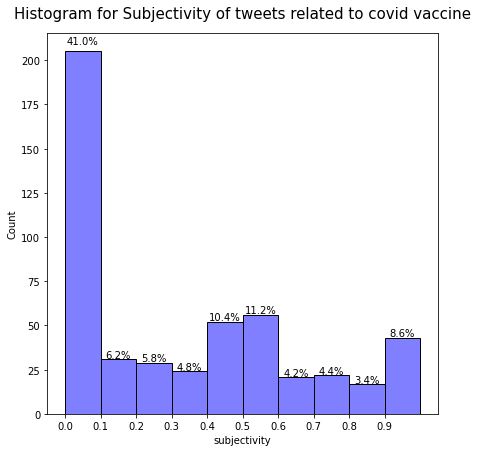

In [13]:
f, ax = plt.subplots(figsize=(7,7))

sns.histplot(tweets_df['subjectivity'],color='blue', ax=ax, alpha=0.5)
ax.set_xticks(np.arange(0, 1, .1))

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    pct_val = round(height/len(tweets_df)*100,2)
    x, y = p.get_xy() 
    ax.annotate(f'{pct_val}%', (x + width/2, y + height*1.02), ha='center')
    ax.set_title("Histogram for Subjectivity of tweets related to covid vaccine", fontsize = 15, pad = 15)

plt.show()

<div class="alert alert-block alert-info">
        <b> Summary </b>
        
It can be seen that around 40% of tweets were objective. 

31.8 % (159) of the tweets have a subjectivity of greater than 50%.
    
If we assume values till 0.3 are objective, then about 57.8% of the tweets are objective. This means that objective and subjective tweets are almost equal in number.
    
</div>

## 5.3 Complimentary hashtag frequency

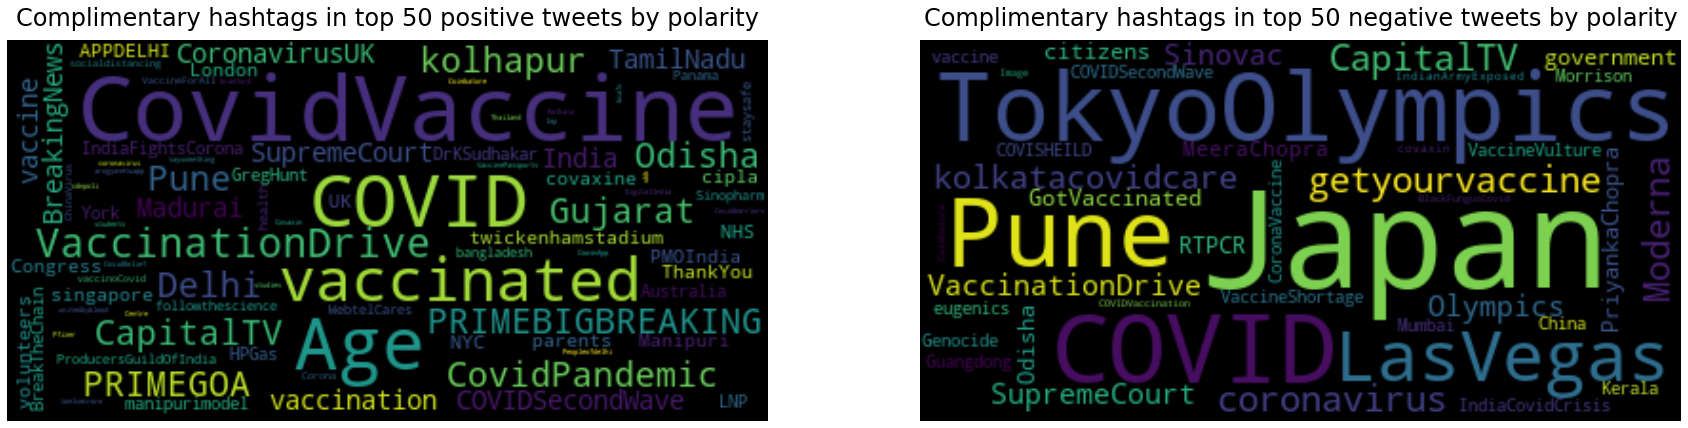

In [14]:
#for tags in tweets_df.query('polarity > 0').loc[:, 'complimentary_hashtags']:

positive_polarity_hashtags = []
negative_polarity_hashtags = []

for idx in range(tweets_df.shape[0]):
    if tweets_df['polarity'].iloc[idx] > 0:
        for i in tweets_df['complimentary_hashtags'].iloc[idx]:
            if (i.lower() != '#covidvaccination' and i!= '#'): positive_polarity_hashtags.append(i)
    elif tweets_df['polarity'].iloc[idx] < 0:
        for i in tweets_df['complimentary_hashtags'].iloc[idx]:
            if (i.lower() != '#covidvaccination' and i!= '#'): negative_polarity_hashtags.append(i) 

f, ax = plt.subplots(1,2, figsize=(30,10))

wordcloud1 = WordCloud().generate((" ").join(positive_polarity_hashtags))
wordcloud2 = WordCloud().generate((" ").join(negative_polarity_hashtags))

# Display the generated image:
ax[0].imshow(wordcloud1, interpolation='bilinear')
ax[1].imshow(wordcloud2, interpolation='bilinear')
ax[0].axis("off")
ax[1].axis("off")
ax[0].set_title("Complimentary hashtags in top 50 positive tweets by polarity", fontsize = 24, pad = 15)
ax[1].set_title("Complimentary hashtags in top 50 negative tweets by polarity", fontsize = 24, pad = 15)

plt.show() 

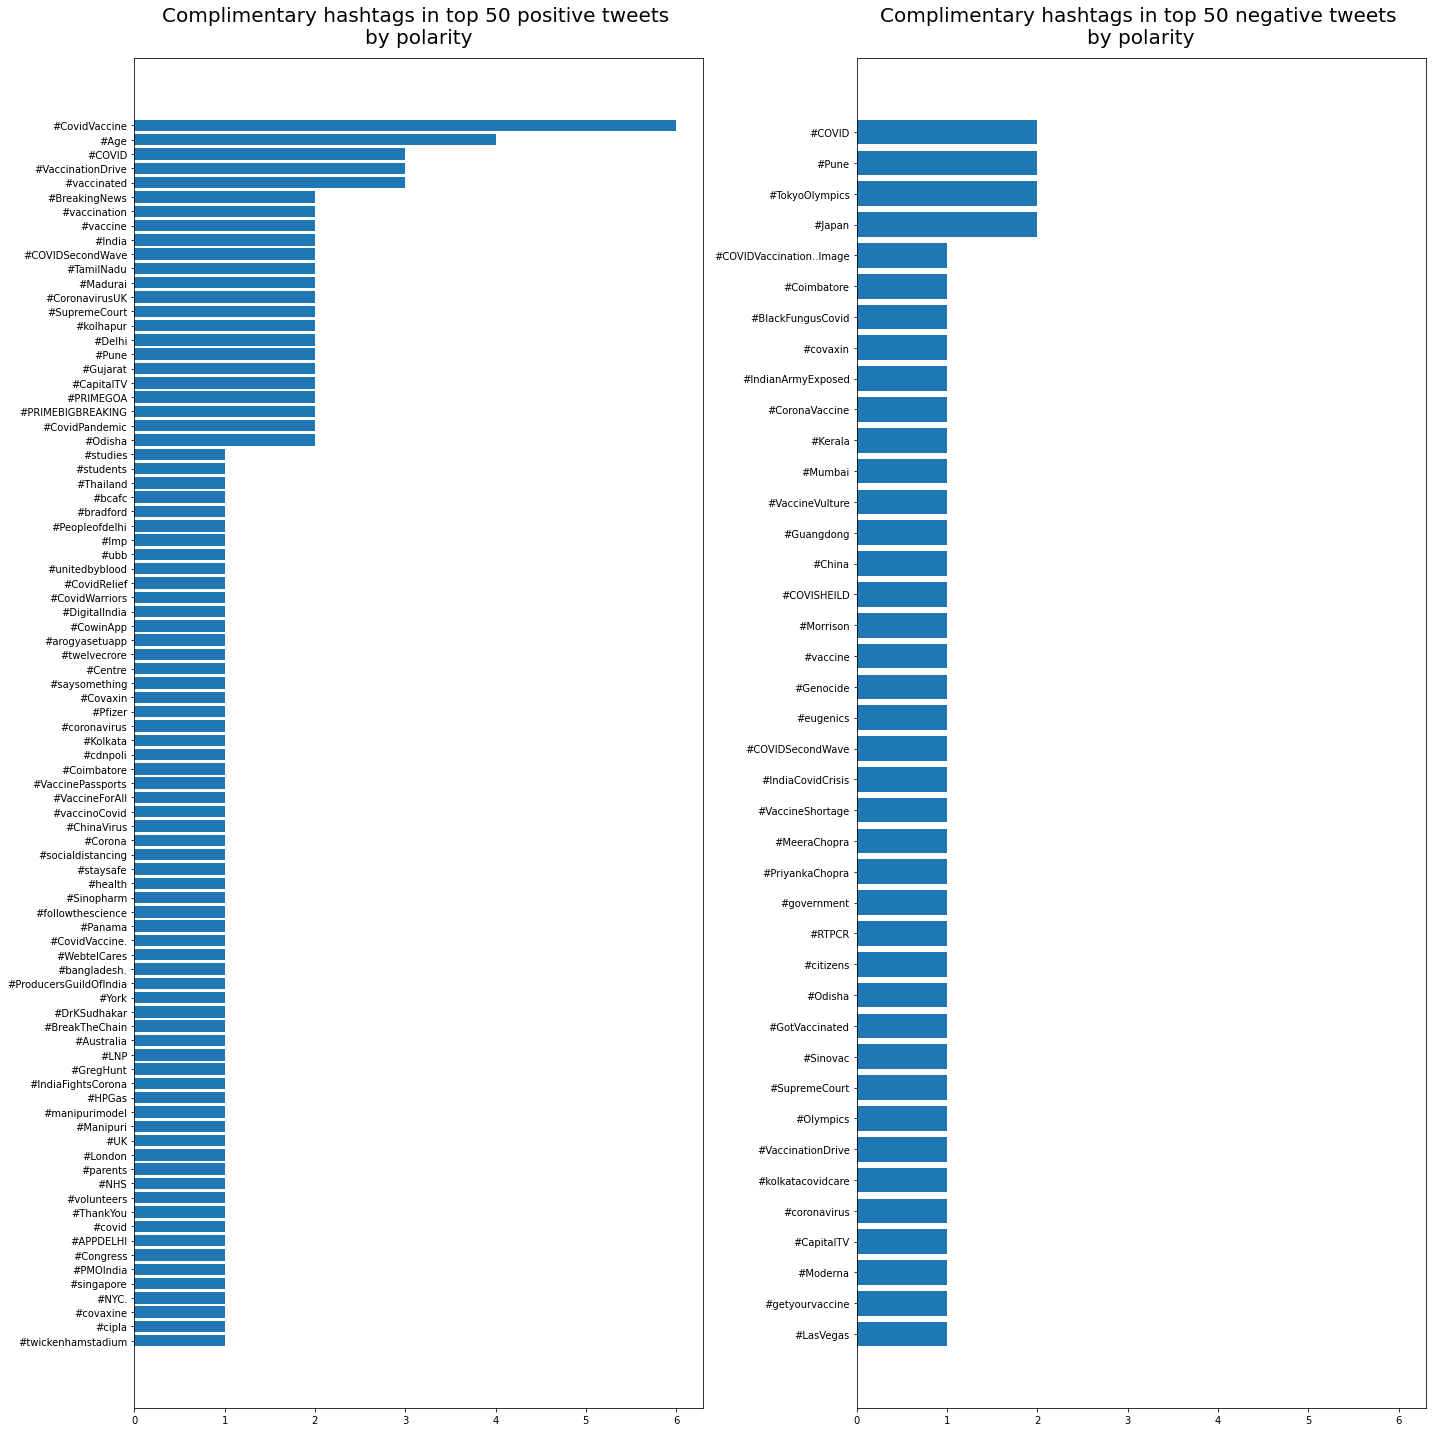

In [19]:
count_positive_polarity_hashtags = dict(sorted(cnt(positive_polarity_hashtags).items(), key=lambda x: x[1]))
count_negative_polarity_hashtags = dict(sorted(cnt(negative_polarity_hashtags).items(), key=lambda x: x[1]))

f, ax = plt.subplots(1, 2, figsize=(20,20))
ax[0].barh(list(count_positive_polarity_hashtags.keys()), list(count_positive_polarity_hashtags.values()))
ax[1].barh(list(count_negative_polarity_hashtags.keys()), list(count_negative_polarity_hashtags.values()))
ax[1].sharex(ax[0])
ax[0].set_title("Complimentary hashtags in top 50 positive tweets \nby polarity", fontsize = 20, pad = 15)
ax[1].set_title("Complimentary hashtags in top 50 negative tweets \nby polarity", fontsize = 20, pad = 15)

for a in f.axes:
    plt.sca(a)
    plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()

<div class="alert alert-block alert-info">
        <b> Summary </b>
        
From complimentary hashtags it can be seen in both positive and negative polarity tweets, a lot of the tweets included hashtags for places [e.g.#India, #Tamilnadu, #CoronavirusUK, #China, #Kerala, #Mumbai].    
It is seen that a lot of the tweets are from India which is facing a massive second wave of the covid pandemic.     
Another commonality with hastags is the vaccines; both positive and negative tweets have mentioned #covaxin, #covishield, etc which are vaccine names.    
 
    
    
Positive tweets also have hashtags of unity and positivity such as #volunteers, #IndiaFightsCorona, #PeopleOfDelhi, #followthescience, etc.   
They also have #Age and #BreakingNews which shows that people are involved in spreading messages and keeping the public informed.
    
Negative tweets on the other hand have negative hashtags like #vaccinevulture, #genocide and #blackfungusCovid which shows that messages against vaccines and worry about the pandemic are prevalant.   
    They also have the issue of Tokyo Olympics where the Japanese Government has declined to heed to its citizens' request to cancel the olympics due to the pandemic. 
                                                                                                                                            
Some of the compimentary hashtags do not provide much context. Tags like #vaccine, #covid, etc are expected to be complimentary.
    
</div>

## 5.4 Word Cloud for top/ bottom 100 tweet sentences by polarity

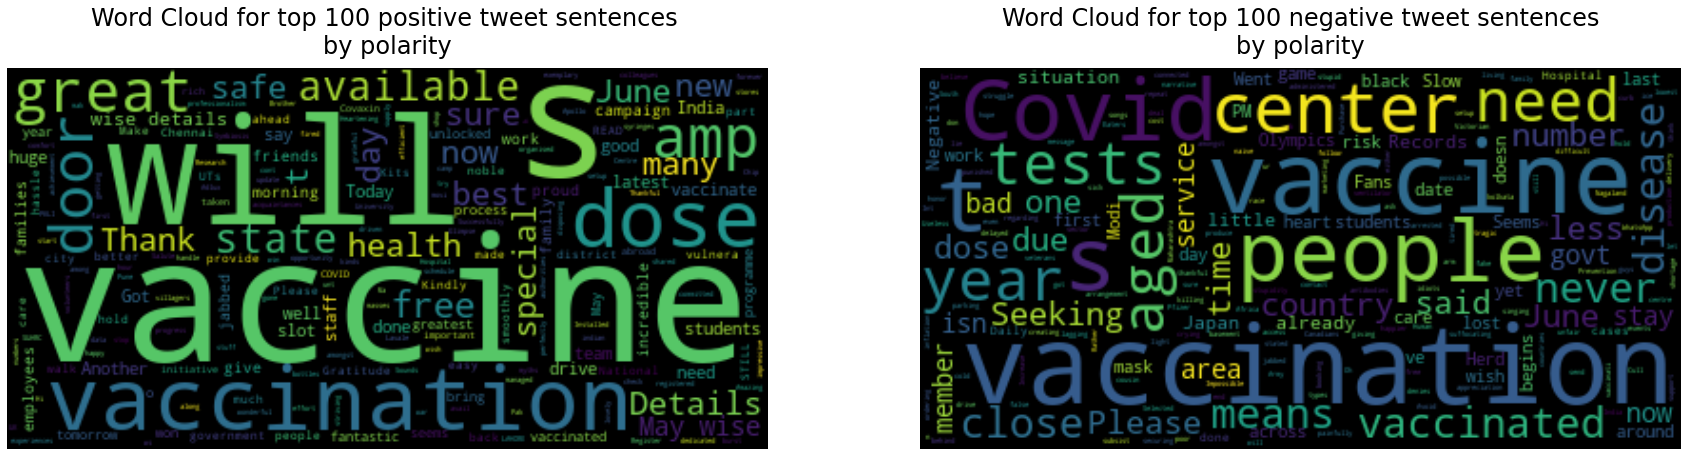

In [26]:
positive_statements =  ' '.join(sentences_df.query('polarity > 0.3').sort_values(by='polarity', ascending=False)['tweet_sentence'])
negative_statements =  ' '.join(sentences_df.query('polarity < 0').sort_values(by='polarity', ascending=True)['tweet_sentence'])

f, ax = plt.subplots(1,2, figsize=(30,10))

wordcloud1 = WordCloud().generate(positive_statements)
wordcloud2 = WordCloud().generate(negative_statements)

# Display the generated image:
ax[0].imshow(wordcloud1, interpolation='bilinear')
ax[1].imshow(wordcloud2, interpolation='bilinear')
ax[0].axis("off")
ax[1].axis("off")
ax[0].set_title("Word Cloud for top 100 positive tweet sentences \nby polarity", fontsize = 24, pad = 15)
ax[1].set_title("Word Cloud for top 100 negative tweet sentences\nby polarity", fontsize = 24, pad = 15)

plt.show()

<div class="alert alert-block alert-info">
        <b> Summary </b>

In positive tweets, people have tweeted about vaccine availabilities.
words such as 'safe', 'dose' tell us that people spread the message for more vaccinations to take place.
    

    
In negative tweets, people have mentioned vaccine 'center', about shortages, about the 'service' and 'care'.
Words like 'hospital', 'delivery', 'seeking', etc again show that people are not satisfied with the availability of vaccination efforts.
Words like 'disease', 'bad', etc show that some tweets talk about the possbile side effects from the vaccine.
    
</div>

## 5.5 Word Cloud for top/ bottom 100 tweet sentences by subjectivity

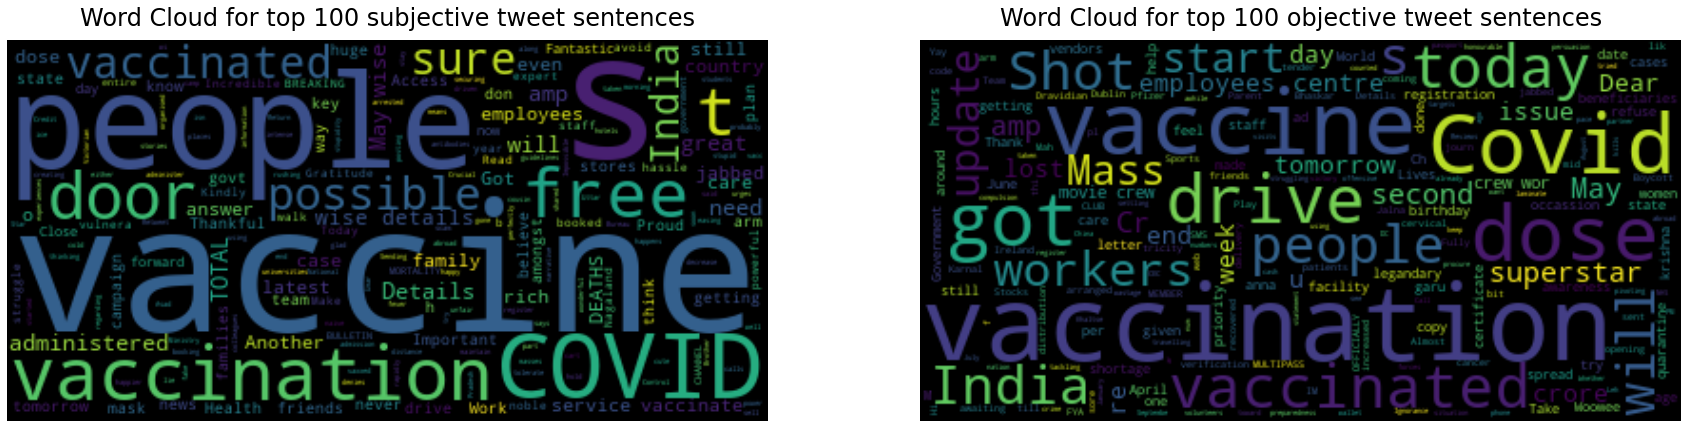

In [17]:
subjective_statements =  ' '.join(sentences_df.sort_values(by='subjectivity', ascending=False)['tweet_sentence'].head(100))
objective_statements =  ' '.join(sentences_df.sort_values(by='subjectivity', ascending=True)['tweet_sentence'].head(100))

f, ax = plt.subplots(1,2, figsize=(30,10))

wordcloud1 = WordCloud().generate(subjective_statements)
wordcloud2 = WordCloud().generate(objective_statements)

# Display the generated image:
ax[0].imshow(wordcloud1, interpolation='bilinear')
ax[1].imshow(wordcloud2, interpolation='bilinear')
ax[0].axis("off")
ax[1].axis("off")
ax[0].set_title("Word Cloud for top 100 subjective tweet sentences", fontsize = 24, pad = 15)
ax[1].set_title("Word Cloud for top 100 objective tweet sentences", fontsize = 24, pad = 15)

plt.show()

<div class="alert alert-block alert-info">
        <b> Summary </b>

In the subjective tweets, people have mentioned about getting vaccinated, vaccines being free in a region. Words like 'people' show that the tweets from this words could were fairly subjective.

    
On the other hand, objective tweets had more specificity - e.g. the word 'update' shows that people talked about specific events. And words like 'drive' talk about specific vaccine drives in regions. 
It is also interesting to note the words 'dose' and 'shot' here since peole objectively define which dose they got.   
Another objective fact is that there are requests to vaccinate specific groups such as 'workers', 'movie crew', etc
    
</div>

<div class="alert alert-block alert-success">
        <b> Recommendations for future vaccination measures </b>

It was seen that most of the tweets were from India which is undergoing a massive second wave of the pandemic.     
    
    
<ul>
 <li>From complimentary hashtags, it can be seen that positive tags and messages like #followthescience, #PeopleOfDelhi, etc were tagged in positive tweets while negative tweets had #vaccinevulture, #genocide, etc. This can be interpreted for future efforts - Governments have to be vigilant in stopping the spread of misinformation regarding vaccines and also encourage the people to share positive experiences from vaccinations to encourage better public vaccination efforts.  </li>
<br>    
 <li>From polarity wordclouds, it is seen that most of the negative tweets talked about unavailability of vaccines and bad service. In future efforts Governments have to do a good job in keeping the public informed about vaccine availability. They also have to bring in additional volunteers to provide good service to the public since regular health workers would already be strained and are more likely to breakdown with difficult people who come for vaccination. </li>
<br>    
 <li>From the subjectivity word cloud, it was seen that objective tweets talked about vaccination drives and specific groups to get vaccinated. This gives an idea for future efforts where Governments can not only prioritize vaccine efforts by age but also by economic groups so that economy is kept in a stable position. Mentions of employees can be interpreted for the future as to plan vaccination drives via employers to make it easy for people to access vaccination efforts.</li>
<br>    
 <li>From the perspective of missing information, it can be seen that there no tags/ words for registrations. This shows that futue efforts should also focus on a proper plan for registration such as an app or website or telephone registrations.</li>
 </ul>
    
</div>

# References
https://stackoverflow.com/questions/58666135/how-to-extract-data-from-a-tweepy-object-into-a-pandas-dataframe

https://www.machinelearningplus.com/nlp/lemmatization-examples-python/

https://www.datacamp.com/community/tutorials/wordcloud-python